# **DEEP LEARNING PROJECT**
**IMAGE CAPTIONING**

KELOMPOK 9:
1. Kent Amadeo Timotheus - 2702227025
2. Theodore Zachary - 2702244100
3. Renaldo - 2702235670

DATASET: Flickr8k Dataset for image captioning.

LINK KAGGLE : https://www.kaggle.com/datasets/adityajn105/flickr8k



# **IMPORT LIBRARIES & SETUP**

In [ ]:
import os
import math
import pickle
import re
from textwrap import wrap
from tqdm import tqdm
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import kagglehub
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Embedding, LSTM, Bidirectional,
                                     Dropout, Concatenate, Layer, LayerNormalization,
                                     GlobalAveragePooling2D, Add)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as effnetv2_preprocess
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# ==================== GOOGLE DRIVE CONNECTION ====================
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_PATH = '/content/drive/MyDrive/ImageCaptioning2'
    os.makedirs(DRIVE_PATH, exist_ok=True)
    print(f"✓ Google Drive mounted at {DRIVE_PATH}")
    USE_DRIVE = True
except:
    DRIVE_PATH = '.'
    USE_DRIVE = False
    print("⚠ Running without Google Drive")

# ==================== DATASET SETUP ====================
path = kagglehub.dataset_download("adityajn105/flickr8k")
print("Dataset path:", path)
IMAGES_DIR = os.path.join(path, "Images")
CAPTION_FILE = os.path.join(path, "captions.txt")
print(f"Images dir exists: {os.path.exists(IMAGES_DIR)}")
print(f"Captions file exists: {os.path.exists(CAPTION_FILE)}")

# ==================== DATA LOADING ====================
import pandas as pd

def load_flickr8k_captions(filepath):
    image_ids = []
    captions = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if len(line) < 10 or line.lower().startswith("image"):
                continue
            if "\t" in line:
                img_id, caption = line.split("\t", 1)
            elif "," in line:
                img_id, caption = line.split(",", 1)
            else:
                parts = line.split(" ", 1)
                if len(parts) != 2:
                    continue
                img_id, caption = parts
            img_id = img_id.split("#")[0].strip()
            if not img_id.endswith(".jpg"):
                continue
            image_ids.append(img_id)
            captions.append(caption.strip())
    df = pd.DataFrame({"image": image_ids, "caption": captions})
    return df

data = load_flickr8k_captions(CAPTION_FILE)
print(f"Total captions loaded: {len(data)}")

Mounted at /content/drive
✓ Google Drive mounted at /content/drive/MyDrive/ImageCaptioning2
Using Colab cache for faster access to the 'flickr8k' dataset.
Dataset path: /kaggle/input/flickr8k
Images dir exists: True
Captions file exists: True
Total captions loaded: 40455


In [ ]:
img_size = 224  # EfficientNetV2B0 optimal size

def readImage(path, image_size=img_size):
    img = load_img(path, target_size=(image_size, image_size))
    img = img_to_array(img)
    img = effnetv2_preprocess(img)
    return img

def display_images(temp_df, image_path, image_size=img_size):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(15, 15))
    n = 0
    for i in range(min(len(temp_df), 15)):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image = readImage(os.path.join(image_path, temp_df['image'][i]), image_size=image_size)
        img_disp = (image - image.min()) / (image.max() - image.min() + 1e-8)
        plt.imshow(img_disp.astype(np.float32))
        plt.title("\n".join(wrap(temp_df['caption'][i], 25)))
        plt.axis('off')
    plt.show()

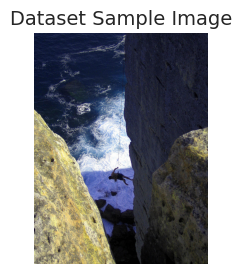

Ground Truth Captions:
1. A man repels down a cliff over water .
2. A mountain climber hangs from a cliff above the ocean .
3. A person descends a rope from a cliff into the ocean .
4. "A person is climbing a cliff wall , over a rocky shore , using a rope ."
5. The man is climbing up the rock .


In [ ]:
import matplotlib.pyplot as plt
import os
import random

def show_image_with_captions(
    df,
    image_path,
    image_col="image",
    caption_col="caption",
    n_captions=5
):
    """
    Menampilkan 1 gambar + n caption ground truth
    """

    # pilih 1 image random
    image_id = random.choice(df[image_col].unique().tolist())

    # ambil caption untuk image tersebut
    captions = df[df[image_col] == image_id][caption_col].tolist()
    captions = captions[:n_captions]

    # bersihkan startseq & endseq
    captions = [
        c.replace("startseq", "").replace("endseq", "").strip()
        for c in captions
    ]

    # load image
    img = plt.imread(os.path.join(image_path, image_id))

    # plot
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Dataset Sample Image", fontsize=14)
    plt.show()

    # print captions
    print("Ground Truth Captions:")
    for i, cap in enumerate(captions, 1):
        print(f"{i}. {cap}")

show_image_with_captions(
    df=data,
    image_path=IMAGES_DIR,
    n_captions=5
)

In [ ]:
import matplotlib.pyplot as plt

# ==================== EDA: BASIC STATISTICS ====================
num_images_dir = len([
    f for f in os.listdir(IMAGES_DIR)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
])

num_unique_images = data['image'].nunique()
num_captions = len(data)

captions_per_image = data.groupby('image').size()

print("📊 EXPLORATORY DATA ANALYSIS (FLICKR8K)")
print("=" * 50)
print(f"Total images in directory      : {num_images_dir}")
print(f"Unique images in captions file : {num_unique_images}")
print(f"Total captions                 : {num_captions}")
print(f"Average captions per image     : {captions_per_image.mean():.2f}")
print(f"Min captions per image         : {captions_per_image.min()}")
print(f"Max captions per image         : {captions_per_image.max()}")

# ==================== DISTRIBUTION CHECK ====================
print("\nCaption distribution per image:")
print(captions_per_image.value_counts().sort_index())


📊 EXPLORATORY DATA ANALYSIS (FLICKR8K)
Total images in directory      : 8091
Unique images in captions file : 8091
Total captions                 : 40455
Average captions per image     : 5.00
Min captions per image         : 5
Max captions per image         : 5

Caption distribution per image:
5    8091
Name: count, dtype: int64


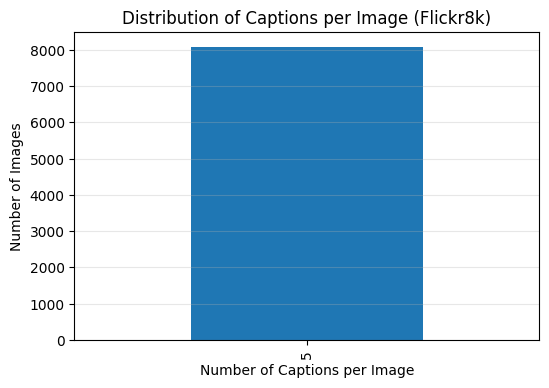

In [ ]:
plt.figure(figsize=(6,4))
captions_per_image.value_counts().sort_index().plot(kind='bar')
plt.xlabel("Number of Captions per Image")
plt.ylabel("Number of Images")
plt.title("Distribution of Captions per Image (Flickr8k)")
plt.grid(axis='y', alpha=0.3)
plt.show()

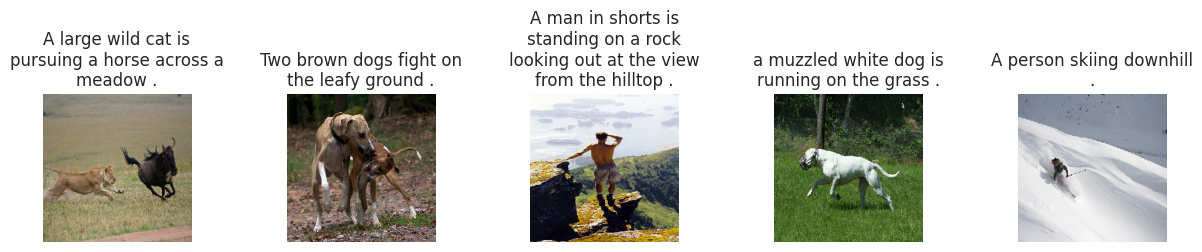

In [ ]:
sample_df = data.sample(5, random_state=42)
display_images(sample_df, IMAGES_DIR)

EXPLORATORY DATA ANALYSIS - FLICKR8K DATASET

📊 BASIC STATISTICS
------------------------------------------------------------
Total number of captions: 40455
Total number of unique images: 8091
Captions per image: 5.00

📏 CAPTION LENGTH ANALYSIS
------------------------------------------------------------
Average caption length (characters): 55.27
Average words per caption: 11.78
Min words: 1, Max words: 38


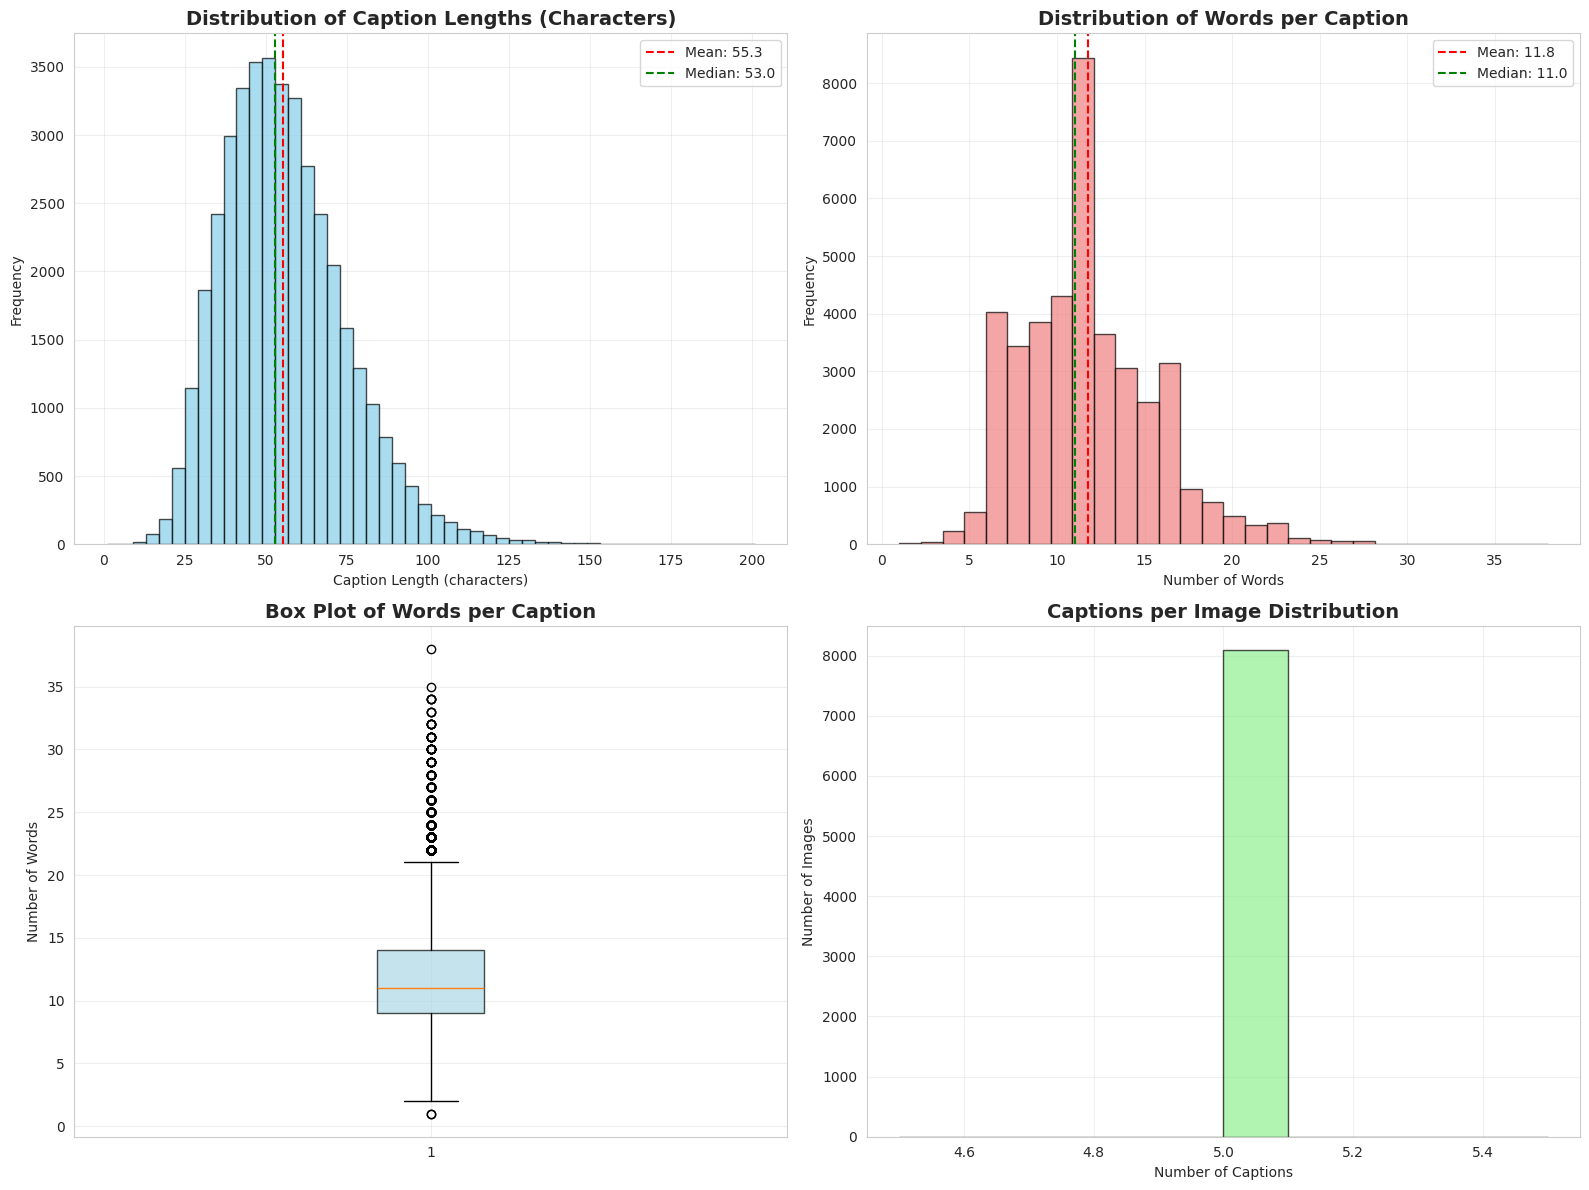


📚 VOCABULARY ANALYSIS
------------------------------------------------------------
Total words (with repetition): 476665
Unique words: 9862

🔝 Top 20 Most Common Words:
 1. a               : 40271 times (8.45%)
 2. .               : 34212 times (7.18%)
 3. A               : 21481 times (4.51%)
 4. in              : 18961 times (3.98%)
 5. the             : 15328 times (3.22%)
 6. on              : 10729 times (2.25%)
 7. is              :  9345 times (1.96%)
 8. and             :  8850 times (1.86%)
 9. dog             :  7982 times (1.67%)
10. with            :  7760 times (1.63%)
11. man             :  6828 times (1.43%)
12. of              :  6712 times (1.41%)
13. Two             :  3962 times (0.83%)
14. white           :  3875 times (0.81%)
15. black           :  3696 times (0.78%)
16. are             :  3503 times (0.73%)
17. boy             :  3442 times (0.72%)
18. woman           :  3227 times (0.68%)
19. girl            :  3217 times (0.67%)
20. ,               :  3210 time

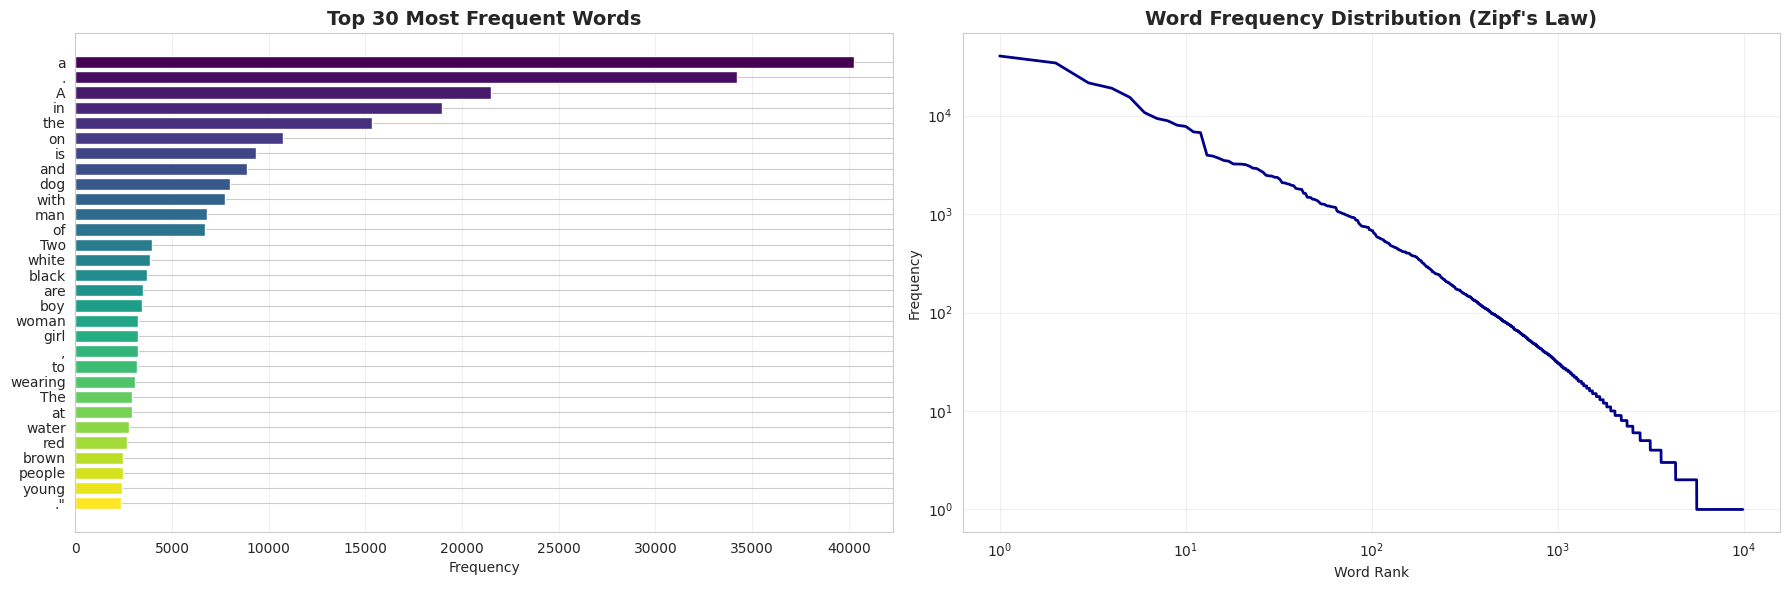


☁️  GENERATING WORD CLOUD
------------------------------------------------------------


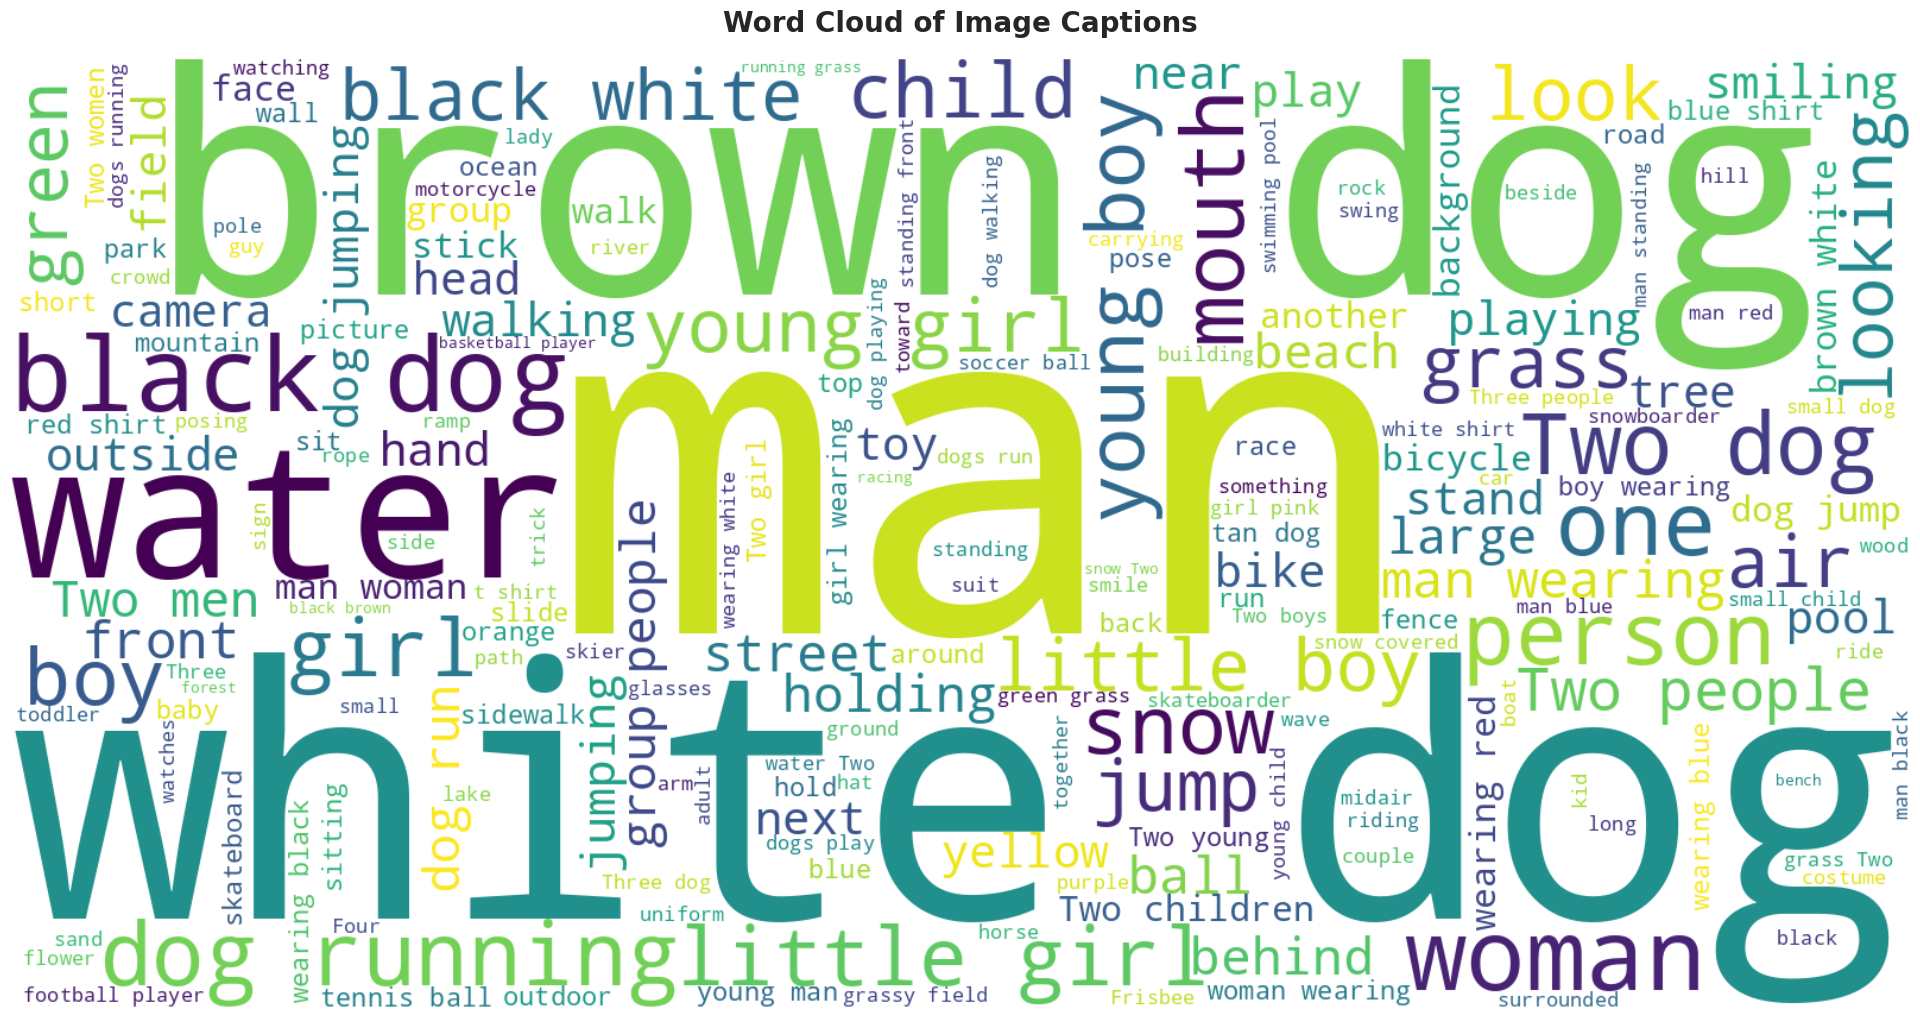


🔍 RARE WORDS ANALYSIS
------------------------------------------------------------
Words appearing less than 5 times: 6729 (68.23%)
Words appearing only once (singletons): 4295 (43.55%)


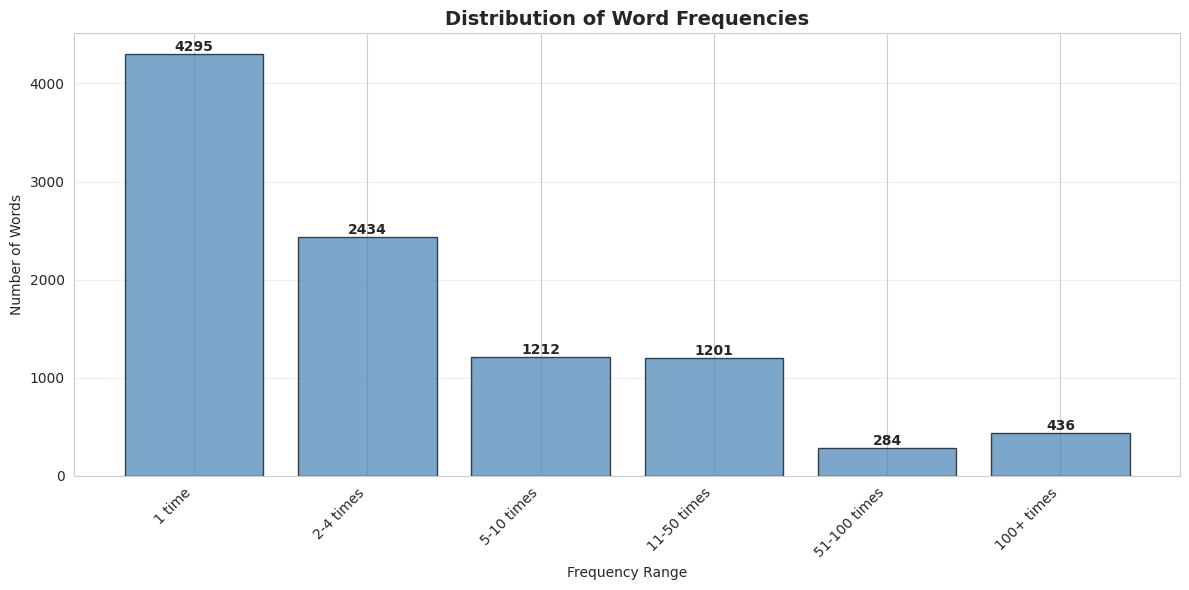

In [ ]:
# ==================== EDA & VISUALIZATION ====================
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
from wordcloud import WordCloud
from textwrap import wrap

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

print("="*60)
print("EXPLORATORY DATA ANALYSIS - FLICKR8K DATASET")
print("="*60)

# ==================== 1. BASIC STATISTICS ====================
print("\n📊 BASIC STATISTICS")
print("-" * 60)
print(f"Total number of captions: {len(data)}")
print(f"Total number of unique images: {len(data['image'].unique())}")
print(f"Captions per image: {len(data) / len(data['image'].unique()):.2f}")

# ==================== 2. CAPTION LENGTH DISTRIBUTION ====================
print("\n📏 CAPTION LENGTH ANALYSIS")
print("-" * 60)

# Calculate lengths (before startseq/endseq)
caption_lengths = []
caption_word_counts = []

for caption in data['caption'].tolist():
    # Remove startseq and endseq for accurate length
    clean_caption = caption.replace('startseq', '').replace('endseq', '').strip()
    words = clean_caption.split()
    caption_lengths.append(len(clean_caption))
    caption_word_counts.append(len(words))

print(f"Average caption length (characters): {np.mean(caption_lengths):.2f}")
print(f"Average words per caption: {np.mean(caption_word_counts):.2f}")
print(f"Min words: {min(caption_word_counts)}, Max words: {max(caption_word_counts)}")

# Plot caption length distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Character length distribution
axes[0, 0].hist(caption_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(np.mean(caption_lengths), color='red', linestyle='--',
                    label=f'Mean: {np.mean(caption_lengths):.1f}')
axes[0, 0].axvline(np.median(caption_lengths), color='green', linestyle='--',
                    label=f'Median: {np.median(caption_lengths):.1f}')
axes[0, 0].set_xlabel('Caption Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Caption Lengths (Characters)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Word count distribution
axes[0, 1].hist(caption_word_counts, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(np.mean(caption_word_counts), color='red', linestyle='--',
                    label=f'Mean: {np.mean(caption_word_counts):.1f}')
axes[0, 1].axvline(np.median(caption_word_counts), color='green', linestyle='--',
                    label=f'Median: {np.median(caption_word_counts):.1f}')
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Words per Caption', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Box plot for word counts
axes[1, 0].boxplot(caption_word_counts, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1, 0].set_ylabel('Number of Words')
axes[1, 0].set_title('Box Plot of Words per Caption', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Captions per image distribution
captions_per_image = data.groupby('image').size()
axes[1, 1].hist(captions_per_image, bins=10, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Number of Captions')
axes[1, 1].set_ylabel('Number of Images')
axes[1, 1].set_title('Captions per Image Distribution', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==================== 3. VOCABULARY ANALYSIS ====================
print("\n📚 VOCABULARY ANALYSIS")
print("-" * 60)

# Get all words
all_words = []
for caption in data['caption'].tolist():
    words = caption.replace('startseq', '').replace('endseq', '').strip().split()
    all_words.extend(words)

word_freq = Counter(all_words)
print(f"Total words (with repetition): {len(all_words)}")
print(f"Unique words: {len(word_freq)}")

# Most common words
print("\n🔝 Top 20 Most Common Words:")
most_common = word_freq.most_common(20)
for i, (word, count) in enumerate(most_common, 1):
    print(f"{i:2d}. {word:15s} : {count:5d} times ({count/len(all_words)*100:.2f}%)")

# Visualize top words
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar chart of top 30 words
top_30 = word_freq.most_common(30)
words, counts = zip(*top_30)
colors = plt.cm.viridis(np.linspace(0, 1, 30))

axes[0].barh(range(len(words)), counts, color=colors)
axes[0].set_yticks(range(len(words)))
axes[0].set_yticklabels(words)
axes[0].invert_yaxis()
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 30 Most Frequent Words', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Word frequency distribution (log scale)
freq_values = sorted(word_freq.values(), reverse=True)
axes[1].plot(range(1, len(freq_values)+1), freq_values, linewidth=2, color='darkblue')
axes[1].set_xlabel('Word Rank')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Word Frequency Distribution (Zipf\'s Law)', fontsize=14, fontweight='bold')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==================== 4. WORD CLOUD ====================
print("\n☁️  GENERATING WORD CLOUD")
print("-" * 60)

# Remove stop words for better visualization
stop_words = {'startseq', 'endseq', 'a', 'an', 'the', 'and', 'is', 'in', 'on', 'at', 'to', 'of'}
filtered_words = [word for word in all_words if word not in stop_words]

wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    colormap='viridis',
    max_words=200,
    relative_scaling=0.5,
    min_font_size=10
).generate(' '.join(filtered_words))

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Image Captions', fontsize=20, fontweight='bold', pad=20)
plt.tight_layout(pad=0)
plt.show()

# ==================== 5. RARE WORDS ANALYSIS ====================
print("\n🔍 RARE WORDS ANALYSIS")
print("-" * 60)

rare_words = [word for word, count in word_freq.items() if count < 5]
singleton_words = [word for word, count in word_freq.items() if count == 1]

print(f"Words appearing less than 5 times: {len(rare_words)} ({len(rare_words)/len(word_freq)*100:.2f}%)")
print(f"Words appearing only once (singletons): {len(singleton_words)} ({len(singleton_words)/len(word_freq)*100:.2f}%)")

# Word frequency bins
freq_bins = {
    '1 time': sum(1 for c in word_freq.values() if c == 1),
    '2-4 times': sum(1 for c in word_freq.values() if 2 <= c <= 4),
    '5-10 times': sum(1 for c in word_freq.values() if 5 <= c <= 10),
    '11-50 times': sum(1 for c in word_freq.values() if 11 <= c <= 50),
    '51-100 times': sum(1 for c in word_freq.values() if 51 <= c <= 100),
    '100+ times': sum(1 for c in word_freq.values() if c > 100)
}

plt.figure(figsize=(12, 6))
bars = plt.bar(freq_bins.keys(), freq_bins.values(), color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Frequency Range')
plt.ylabel('Number of Words')
plt.title('Distribution of Word Frequencies', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# ==================== IMAGE PROCESSING ====================
img_size = 224  # EfficientNetV2B0 optimal size

# ==================== TEXT PREPROCESSING (IMPROVED) ====================
def text_preprocessing(df, caption_col='caption'):
    df[caption_col] = df[caption_col].astype(str).str.strip()
    df[caption_col] = df[caption_col].str.lower()
    # Remove multiple spaces
    df[caption_col] = df[caption_col].apply(lambda x: re.sub(r'\s+', ' ', x))
    # Keep only alphanumeric and basic punctuation
    df[caption_col] = df[caption_col].apply(
        lambda x: re.sub(r"[^a-z0-9\s]", "", x)
    )
    # Add start and end tokens
    df[caption_col] = df[caption_col].apply(
        lambda x: "startseq " + x.strip() + " endseq"
    )
    return df

data = text_preprocessing(data)
captions = data['caption'].tolist()

# ==================== TOKENIZATION (IMPROVED) ====================
# Filter out rare words to reduce vocab size
word_counts = Counter()
for caption in captions:
    word_counts.update(caption.split())

# Keep words that appear at least 5 times
min_word_freq = 5
filtered_captions = []
for caption in captions:
    words = caption.split()
    filtered = [w if word_counts[w] >= min_word_freq else '<unk>' for w in words]
    filtered_captions.append(' '.join(filtered))

tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(filtered_captions)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

max_length = max(len(c.split()) for c in captions)
print(f"Max caption length: {max_length}")

# Update data with filtered captions
data['caption'] = filtered_captions

Vocabulary size: 2996
Max caption length: 38


In [ ]:
# ==================== TRAIN/VAL SPLIT ====================
images = data['image'].unique().tolist()
nimages = len(images)
print(f"Number of unique images: {nimages}")

split_index = round(nimages * 0.85)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)].reset_index(drop=True)
val = data[data['image'].isin(val_images)].reset_index(drop=True)

print(f"Train captions: {len(train)}, Val captions: {len(val)}")

# Save tokenizer
tokenizer_path = os.path.join(DRIVE_PATH if USE_DRIVE else '.', 'tokenizer.pkl')
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"✓ Tokenizer saved to {tokenizer_path}")

Number of unique images: 8091
Train captions: 34385, Val captions: 6070
✓ Tokenizer saved to /content/drive/MyDrive/ImageCaptioning2/tokenizer.pkl


In [ ]:
# ==================== FEATURE EXTRACTION (EfficientNetV2B0) ====================
feature_path = os.path.join(DRIVE_PATH if USE_DRIVE else '.', 'features_effnetv2b0.pkl')

if os.path.exists(feature_path):
    print(f"Loading pre-extracted features from {feature_path}")
    with open(feature_path, 'rb') as f:
        features = pickle.load(f)
    print(f"✓ Loaded {len(features)} features")
else:
    print("Extracting features using EfficientNetV2B0...")
    base_model = EfficientNetV2B0(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3),
        pooling=None
    )
    # Use the last conv block for better spatial features
    fe_model = Model(inputs=base_model.input, outputs=base_model.output)

    features = {}
    for image in tqdm(data['image'].unique(), desc="Extracting features"):
        img_path = os.path.join(IMAGES_DIR, image)
        if not os.path.exists(img_path):
            continue
        img = readImage(img_path, image_size=img_size)
        img = np.expand_dims(img, axis=0)
        feat_map = fe_model.predict(img, verbose=0)[0]
        h, w, c = feat_map.shape
        features[image] = feat_map.reshape(-1, c).astype(np.float32)

    # Save features
    with open(feature_path, 'wb') as f:
        pickle.dump(features, f)
    print(f"✓ Features saved to {feature_path}")

sample_feature = next(iter(features.values()))
num_patches, feat_dim = sample_feature.shape
print(f"Feature shape: ({num_patches}, {feat_dim})")

Loading pre-extracted features from /content/drive/MyDrive/ImageCaptioning2/features_effnetv2b0.pkl
✓ Loaded 8091 features
Feature shape: (49, 1280)



🎯 FEATURE EXTRACTION INFO
------------------------------------------------------------
Number of images with features: 8091
Feature shape per image: (49, 1280)
Number of spatial patches: 49
Feature dimension: 1280


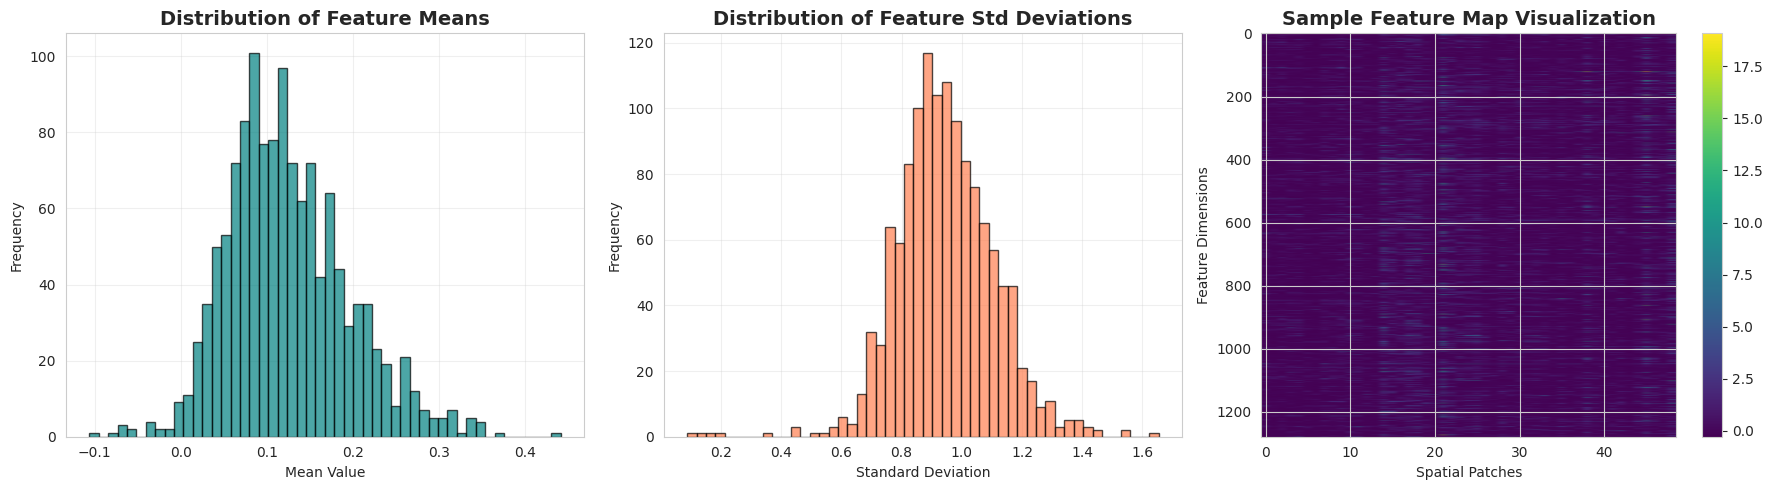


✓ EDA COMPLETE!


In [ ]:
# ==================== FEATURE EXTRACTION INFO ====================
if 'features' in locals():
    print("\n🎯 FEATURE EXTRACTION INFO")
    print("-" * 60)
    print(f"Number of images with features: {len(features)}")
    print(f"Feature shape per image: {sample_feature.shape}")
    print(f"Number of spatial patches: {num_patches}")
    print(f"Feature dimension: {feat_dim}")

    # Visualize feature statistics
    all_features = np.vstack(list(features.values()))

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Feature mean distribution
    axes[0].hist(all_features.mean(axis=0), bins=50, color='teal', edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Mean Value')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Feature Means', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Feature std distribution
    axes[1].hist(all_features.std(axis=0), bins=50, color='coral', edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Standard Deviation')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Feature Std Deviations', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    # Sample feature heatmap
    sample_feat = list(features.values())[0]
    im = axes[2].imshow(sample_feat.T, aspect='auto', cmap='viridis')
    axes[2].set_xlabel('Spatial Patches')
    axes[2].set_ylabel('Feature Dimensions')
    axes[2].set_title('Sample Feature Map Visualization', fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=axes[2])

    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("✓ EDA COMPLETE!")
print("="*60)

In [ ]:
# ==================== DATA GENERATOR ====================
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, tokenizer,
                 vocab_size, max_length, features_dict, shuffle=True):
        super().__init__()
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features_dict
        self.shuffle = shuffle
        self.n = len(self.df)
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return int(np.ceil(self.n / float(self.batch_size)))

    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
        X1, X2, y = [], [], []
        for _, row in batch.iterrows():
            image = row[self.X_col]
            caption = row[self.y_col]
            if image not in self.features:
                continue
            feature = self.features[image]
            seq = self.tokenizer.texts_to_sequences([caption])[0]
            for i in range(1, len(seq)):
                in_seq = seq[:i]
                out_seq = seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length, padding='post')[0]
                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)

        X1 = np.array(X1, dtype=np.float32)
        X2 = np.array(X2, dtype=np.int32)
        y = np.array(y, dtype=np.int32)
        return X1, X2, y

In [ ]:
from tensorflow.keras.saving import register_keras_serializable

# ==================== IMPROVED ATTENTION MECHANISM ====================
@register_keras_serializable()
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W1 = Dense(self.units, use_bias=False)
        self.W2 = Dense(self.units, use_bias=False)
        self.V = Dense(1, use_bias=False)
        super().build(input_shape)

    def call(self, inputs):
        encoder_features, decoder_hidden = inputs
        decoder_hidden = tf.expand_dims(decoder_hidden, 1)
        score = tf.nn.tanh(self.W1(encoder_features) + self.W2(decoder_hidden))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = tf.reduce_sum(attention_weights * encoder_features, axis=1)
        return context_vector, tf.squeeze(attention_weights, -1)

    # def get_config(self):
    #     config = super().get_config()
    #     config.update({"units": self.units})
    #     return config

In [ ]:
# ==================== MODEL ARCHITECTURE (IMPROVED) ====================
print("\n Building improved model...")

encoder_input = Input(shape=(num_patches, feat_dim), name='image_features')
decoder_input = Input(shape=(max_length,), name='decoder_input')

# Embedding with higher dimension
embedding_dim = 512
embed = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    mask_zero=True,
    name='embed'
)(decoder_input)

# Apply dropout to embedding
embed = Dropout(0.3)(embed)

# Single LSTM layer with more units (more efficient than BiLSTM for this task)
lstm_out = LSTM(
    512,
    return_sequences=False,
    dropout=0.3,
    recurrent_dropout=0.2,
    name='lstm'
)(embed)

# Layer normalization for stability
lstm_out = LayerNormalization()(lstm_out)

# Attention mechanism
attention_units = 512
attention = BahdanauAttention(attention_units)
context_vector, att_weights = attention([encoder_input, lstm_out])

# Concatenate context + decoder hidden
concat = Concatenate(axis=-1)([context_vector, lstm_out])

# Dense layers with residual-like connection
x = Dense(512, activation='relu')(concat)
x = Dropout(0.4)(x)
x = LayerNormalization()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer
outputs = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[encoder_input, decoder_input], outputs=outputs)


caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=3e-4,
        clipnorm=1.0
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

caption_model.summary()


 Building improved model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 38)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed (Embedding)   │ (None, 38, 512)   │  1,533,952 │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 38, 512)   │          0 │ embed[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 38)        │          0 │ decoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 512)       │  2,099,200 │ dropout[0][0],    │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_features      │ (None, 49, 1280)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 512)       │      1,024 │ lstm[0][0]        │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention  │ [(None, 1280),    │    918,016 │ image_features[0… │
│ (BahdanauAttention) │ (None, 49)]       │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1792)      │          0 │ bahdanau_attenti… │
│ (Concatenate)       │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    918,016 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 512)       │      1,024 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2996)      │    769,972 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,372,532 (24.31 MB)

 Trainable params: 6,372,532 (24.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import load_model

# ==================== TRAINING ====================
batch_size = 128

train_generator = CustomDataGenerator(
    df=train, X_col='image', y_col='caption',
    batch_size=batch_size, tokenizer=tokenizer,
    vocab_size=vocab_size, max_length=max_length,
    features_dict=features, shuffle=True
)

validation_generator = CustomDataGenerator(
    df=val, X_col='image', y_col='caption',
    batch_size=batch_size, tokenizer=tokenizer,
    vocab_size=vocab_size, max_length=max_length,
    features_dict=features, shuffle=False
)

# ==================== MODEL PATH ====================
BASE_PATH = DRIVE_PATH if USE_DRIVE else '.'
MODEL_NAME = 'caption_model_effnetv2b0.keras'
model_path = os.path.join(BASE_PATH, MODEL_NAME)

# ==================== LOAD MODEL IF EXISTS ====================
if os.path.exists(model_path):
    print(f"📦 Found existing model → loading from {model_path}")
    caption_model = load_model(model_path)
    print("✅ Model successfully loaded")
else:
    print("🆕 No existing model found → training from scratch")

    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )

    earlystopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        patience=2,
        factor=0.5,
        min_lr=1e-7,
        verbose=1
    )

    print("\n🚀 Starting training...")
    history = caption_model.fit(
        train_generator,
        epochs=13,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, reduce_lr],
        verbose=1
    )

    # ==================== SAVE HISTORY ====================
    history_path = os.path.join(BASE_PATH, 'training_history.pkl')
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

    print(f"✓ Training history saved to {history_path}")

🆕 No existing model found → training from scratch

🚀 Starting training...
Epoch 1/13
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - loss: 5.3510 - sparse_categorical_accuracy: 0.1889
Epoch 1: val_loss improved from inf to 3.75920, saving model to /content/drive/MyDrive/ImageCaptioning2/caption_model_effnetv2b0.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 220s 758ms/step - loss: 5.3480 - sparse_categorical_accuracy: 0.1891 - val_loss: 3.7592 - val_sparse_categorical_accuracy: 0.3395 - learning_rate: 3.0000e-04
Epoch 2/13
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - loss: 3.6302 - sparse_categorical_accuracy: 0.3280
Epoch 2: val_loss improved from 3.75920 to 3.40036, saving model to /content/drive/MyDrive/ImageCaptioning2/caption_model_effnetv2b0.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 204s 756ms/step - loss: 3.6299 - sparse_categorical_accuracy: 0.3280 - val_loss: 3.4004 - val_sparse_categorical_accuracy: 0.3698 - learning_rate: 3.0000e-04
Epoch 3/13
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - loss: 3.

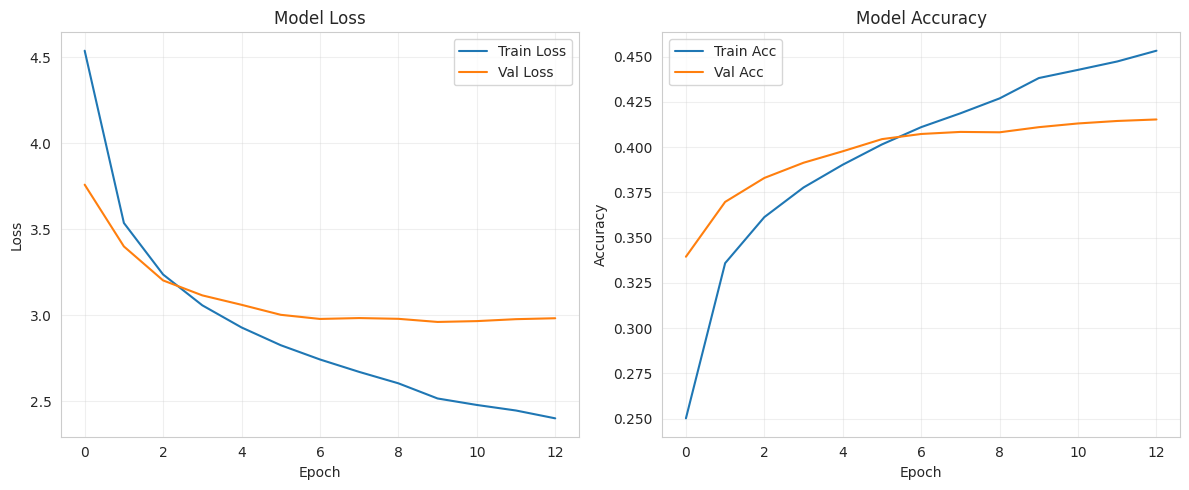

✓ Plot saved to /content/drive/MyDrive/ImageCaptioning2/training_plot.png


In [ ]:
# ==================== PLOT TRAINING HISTORY ====================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(DRIVE_PATH if USE_DRIVE else '.', 'training_plot.png')
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Plot saved to {plot_path}")

In [ ]:
# ==================== PREDICTION FUNCTIONS ====================
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def clean_caption(raw_caption):
    caption = raw_caption.replace('startseq', '').replace('endseq', '').strip()
    caption = caption.capitalize()
    if caption and not caption.endswith('.'):
        caption = caption + '.'
    return caption

def beam_search_predictions(model, tokenizer, feature, max_length, beam_index):
    start_token = tokenizer.word_index.get('startseq')
    end_token = tokenizer.word_index.get('endseq')

    if start_token is None or end_token is None:
        raise ValueError("startseq/endseq tokens missing in tokenizer")

    sequences = [[[start_token], 0.0]]

    for _ in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            if seq[-1] == end_token:
                all_candidates.append((seq, score))
                continue

            sequence = pad_sequences([seq], maxlen=max_length, padding='post')
            yhat = model.predict([feature[np.newaxis, ...], sequence], verbose=0)[0]

            # Get top-k predictions
            top_indices = np.argsort(yhat)[-beam_index:]
            for idx in top_indices:
                prob = yhat[idx]
                if prob <= 1e-6:
                    continue
                candidate_seq = seq + [int(idx)]
                candidate_score = score - np.log(prob + 1e-10)
                all_candidates.append((candidate_seq, candidate_score))

        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_index]

        if all(s[-1] == end_token for s, _ in sequences):
            break

    best_seq = sequences[0][0]
    words = [idx_to_word(i, tokenizer) for i in best_seq]
    caption = " ".join([w for w in words if w is not None])
    return clean_caption(caption)

def predict_caption_beam(model, image_key, tokenizer, max_length,
                        features_dict, beam_index):
    feature = features_dict[image_key]
    return beam_search_predictions(model, tokenizer, feature, max_length, beam_index)


In [ ]:
# ==================== EVALUATION METRICS ====================
def lcs_length(x, y):
    m, n = len(x), len(y)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(m):
        for j in range(n):
            if x[i] == y[j]:
                dp[i + 1][j + 1] = dp[i][j] + 1
            else:
                dp[i + 1][j + 1] = max(dp[i][j + 1], dp[i + 1][j])
    return dp[m][n]

def rouge_l_score(reference_tokens_list, hypothesis_tokens):
    best_f = 0.0
    for ref in reference_tokens_list:
        lcs = lcs_length(ref, hypothesis_tokens)
        if lcs == 0:
            continue
        prec = lcs / len(hypothesis_tokens) if len(hypothesis_tokens) > 0 else 0
        rec = lcs / len(ref) if len(ref) > 0 else 0
        if prec + rec == 0:
            f = 0.0
        else:
            f = (2 * prec * rec) / (prec + rec)
        best_f = max(best_f, f)
    return best_f

def build_idf(references_per_image):
    df = Counter()
    N = len(references_per_image)
    for refs in references_per_image.values():
        words = set()
        for r in refs:
            words.update(r)
        for w in words:
            df[w] += 1
    idf = {}
    for w, c in df.items():
        idf[w] = math.log((N + 1) / (c + 1)) + 1.0
    return idf

def cider_like_score(ref_tokens_list, hyp_tokens, idf):
    tf_ref = Counter()
    tf_hyp = Counter(hyp_tokens)
    for ref in ref_tokens_list:
        tf_ref.update(ref)

    ref_vec = {w: tf * idf.get(w, 0.0) for w, tf in tf_ref.items()}
    hyp_vec = {w: tf * idf.get(w, 0.0) for w, tf in tf_hyp.items()}

    common = set(ref_vec.keys()) & set(hyp_vec.keys())
    dot = sum(ref_vec[w] * hyp_vec[w] for w in common)

    ref_norm = math.sqrt(sum(v * v for v in ref_vec.values()))
    hyp_norm = math.sqrt(sum(v * v for v in hyp_vec.values()))

    if ref_norm == 0 or hyp_norm == 0:
        return 0.0
    return dot / (ref_norm * hyp_norm)

def build_references(df):
    refs = defaultdict(list)
    for _, row in df.iterrows():
        img = row['image']
        cap = row['caption']
        cap = cap.replace('startseq', '').replace('endseq', '').strip()
        tokens = cap.lower().split()
        refs[img].append(tokens)
    return refs

def evaluate_caption_model(model, tokenizer, features_dict, val_df,
                          max_length, beam_index):
    references_per_image = build_references(val_df)
    idf = build_idf(references_per_image)
    smoothie = SmoothingFunction().method4

    bleu1_scores, bleu2_scores = [], []
    bleu3_scores, bleu4_scores = [], []
    meteor_scores, rougeL_scores, cider_scores = [], [], []

    all_images = list(references_per_image.keys())

    for img_id in tqdm(all_images, desc="Evaluating"):
        if img_id not in features_dict:
            continue

        hyp_caption = predict_caption_beam(
            model, img_id, tokenizer, max_length,
            features_dict, beam_index=beam_index
        )
        hyp_tokens = hyp_caption.lower().replace('.', '').split()
        ref_tokens_list = references_per_image[img_id]

        bleu1 = sentence_bleu(ref_tokens_list, hyp_tokens,
                             weights=(1, 0, 0, 0), smoothing_function=smoothie)
        bleu2 = sentence_bleu(ref_tokens_list, hyp_tokens,
                             weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
        bleu3 = sentence_bleu(ref_tokens_list, hyp_tokens,
                             weights=(1/3, 1/3, 1/3, 0), smoothing_function=smoothie)
        bleu4 = sentence_bleu(ref_tokens_list, hyp_tokens,
                             weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

        meteors = [meteor_score([r], hyp_tokens) for r in ref_tokens_list]
        meteor_val = max(meteors) if meteors else 0.0

        rouge_l = rouge_l_score(ref_tokens_list, hyp_tokens)
        cider_val = cider_like_score(ref_tokens_list, hyp_tokens, idf)

        bleu1_scores.append(bleu1)
        bleu2_scores.append(bleu2)
        bleu3_scores.append(bleu3)
        bleu4_scores.append(bleu4)
        meteor_scores.append(meteor_val)
        rougeL_scores.append(rouge_l)
        cider_scores.append(cider_val)

    print("\n" + "="*50)
    print("📊 EVALUATION RESULTS (Validation Set)")
    print("="*50)
    print(f"BLEU-1 : {np.mean(bleu1_scores):.4f}")
    print(f"BLEU-2 : {np.mean(bleu2_scores):.4f}")
    print(f"BLEU-3 : {np.mean(bleu3_scores):.4f}")
    print(f"BLEU-4 : {np.mean(bleu4_scores):.4f}")
    print(f"METEOR : {np.mean(meteor_scores):.4f}")
    print(f"ROUGE-L: {np.mean(rougeL_scores):.4f}")
    print(f"CIDEr* : {np.mean(cider_scores):.4f}")
    print("="*50)

    return {
        'bleu1': np.mean(bleu1_scores),
        'bleu2': np.mean(bleu2_scores),
        'bleu3': np.mean(bleu3_scores),
        'bleu4': np.mean(bleu4_scores),
        'meteor': np.mean(meteor_scores),
        'rougeL': np.mean(rougeL_scores),
        'cider_like': np.mean(cider_scores)
    }

# ==================== RUN EVALUATION ====================
print("\n🔍 Evaluating model...")
metrics = evaluate_caption_model(
    caption_model, tokenizer, features,
    val, max_length=max_length, beam_index=7
)

# Save metrics
metrics_path = os.path.join(DRIVE_PATH if USE_DRIVE else '.', 'evaluation_metrics.pkl')
with open(metrics_path, 'wb') as f:
    pickle.dump(metrics, f)
print(f"✓ Metrics saved to {metrics_path}")


🔍 Evaluating model...


Evaluating: 100%|██████████| 1214/1214 [2:31:44<00:00,  7.50s/it]


📊 EVALUATION RESULTS (Validation Set)
BLEU-1 : 0.5951
BLEU-2 : 0.4238
BLEU-3 : 0.2895
BLEU-4 : 0.1995
METEOR : 0.3996
ROUGE-L: 0.4517
CIDEr* : 0.3013
✓ Metrics saved to /content/drive/MyDrive/ImageCaptioning2/evaluation_metrics.pkl



📷 Generating sample predictions...


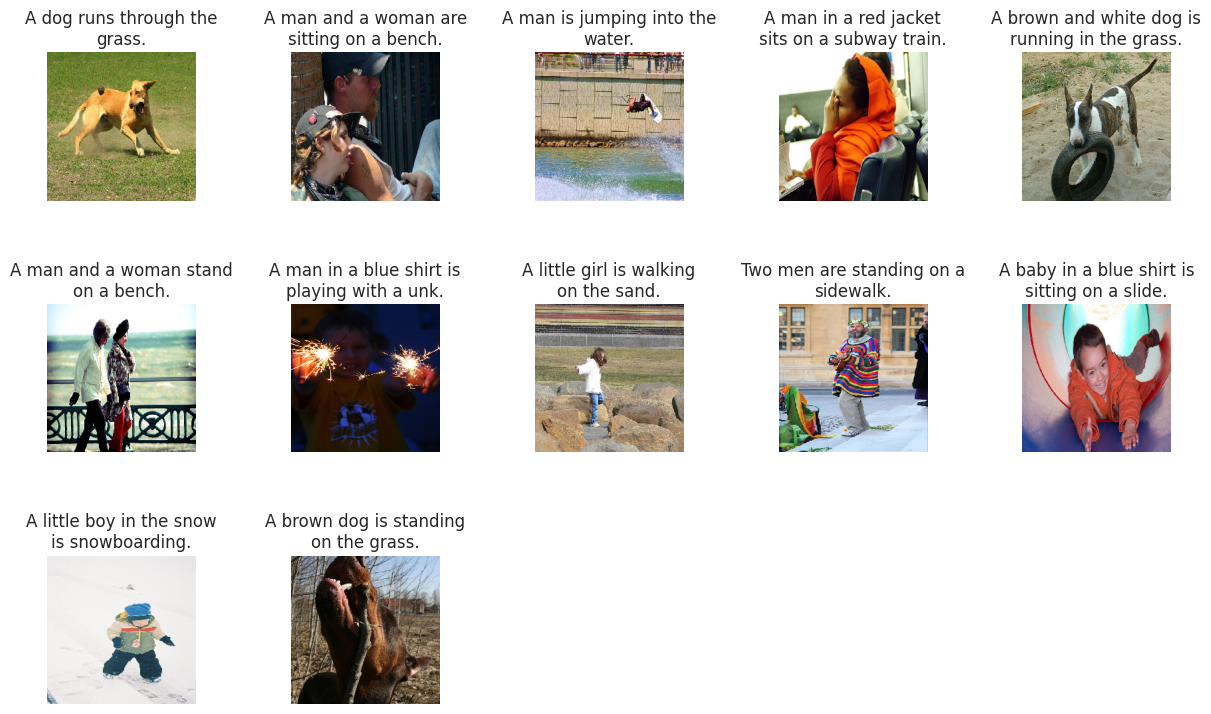

In [ ]:
# ==================== VISUALIZE PREDICTIONS ====================
print("\n📷 Generating sample predictions...")
samples = val.sample(min(12, len(val))).reset_index(drop=True)
samples['pred_caption'] = ""

for idx, row in samples.iterrows():
    if row['image'] not in features:
        continue
    pred = predict_caption_beam(
        caption_model, row['image'], tokenizer,
        max_length, features, beam_index=5
    )
    samples.at[idx, 'pred_caption'] = pred

samples_disp = samples.copy()
samples_disp['caption'] = samples_disp['pred_caption']
display_images(samples_disp, IMAGES_DIR, image_size=img_size)

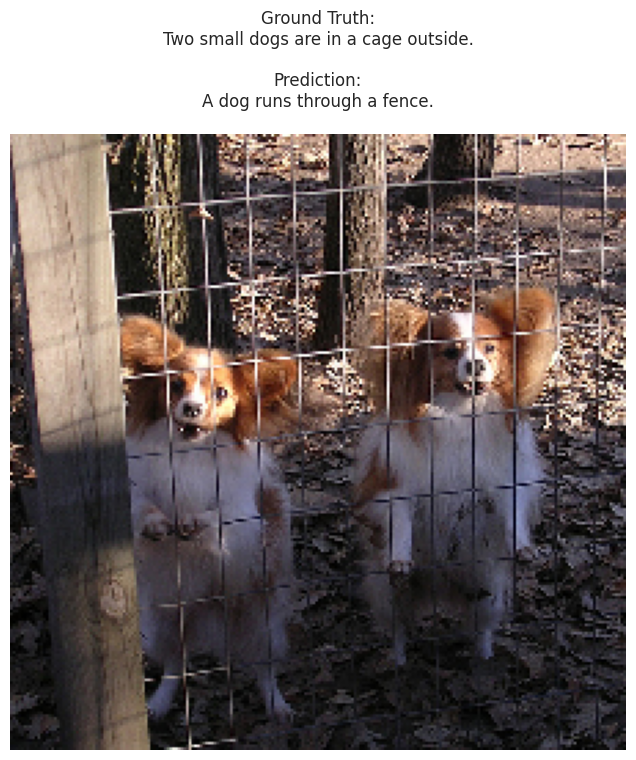

✓ Sample comparison saved to /content/drive/MyDrive/ImageCaptioning2/sample_comparison.png


In [ ]:
# ==================== SINGLE IMAGE COMPARISON ====================
sample = val.sample(1).iloc[0]
if sample['image'] in features:
    pred_caption = predict_caption_beam(
        caption_model, sample['image'], tokenizer,
        max_length, features, beam_index=5
    )
    true_caption = clean_caption(sample['caption'])

    img_path = os.path.join(IMAGES_DIR, sample['image'])
    img = load_img(img_path, target_size=(img_size, img_size))

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Ground Truth:\n{true_caption}\n\nPrediction:\n{pred_caption}",
              fontsize=12, pad=20)

    comparison_path = os.path.join(DRIVE_PATH if USE_DRIVE else '.', 'sample_comparison.png')
    plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Sample comparison saved to {comparison_path}")

In [ ]:
print("\n✅ Training and evaluation complete!")
if USE_DRIVE:
    print(f"📁 All files saved to Google Drive: {DRIVE_PATH}")


✅ Training and evaluation complete!
📁 All files saved to Google Drive: /content/drive/MyDrive/ImageCaptioning2
